In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
from tqdm import trange, tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import polars as pl

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

# Read the classified events

In [5]:
# Samples to do
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]

cls_df = pl.concat([
    pl.read_parquet(
        str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.classified_reads.parquet")
    ) \
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
])

In [6]:
trusty_cls_df = (cls_df
    .filter(~pl.col("has_common_transition"))
    .filter(pl.col("min_coverage_between_transitions_hap1") >= 3)
    .filter(pl.col("min_coverage_between_transitions_hap2") >= 3)
)

In [55]:
trusty_cls_df.group_by("sample_id").len()

sample_id,len
str,u32
"""PD50477f""",370
"""PD50521b""",491
"""PD50508b""",260
"""PD50508f""",176
"""PD50521e""",347
"""PD46180c""",469
"""PD50489e""",256
"""PD50519d""",326
"""PD50523b""",360


In [56]:
age_dict = {
    "PD46180c": 24,
    "PD50477f": 74,
    "PD50489e": 47,
    "PD50502f": 57,
    "PD50508b": 62,
    "PD50508f": 74,
    "PD50511e": 55,
    "PD50519d": 36,
    "PD50521b": 27,
    "PD50521e": 40,
    "PD50523b": 26,
}

In [64]:
age_df = pl.DataFrame({
    "sample_id": list(age_dict.keys()),
    "age": list(age_dict.values()),
})

age_df = trusty_cls_df.group_by("sample_id").len().join(age_df, on="sample_id")

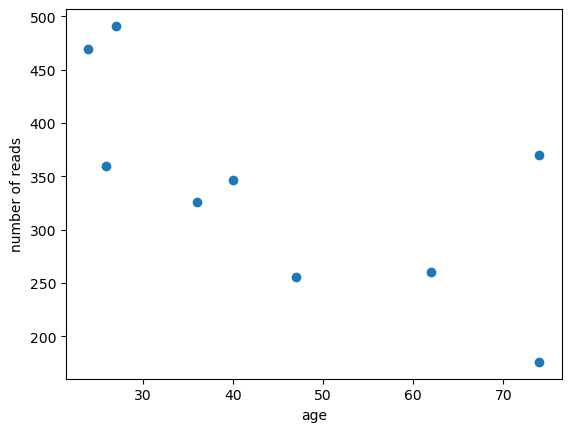

In [66]:
plt.scatter(
    age_df["age"],
    age_df["len"],
)
plt.xlabel("age");
plt.ylabel("number of reads");

In [71]:
np.max(age_df["len"].to_numpy())

491

In [85]:
(trusty_cls_df
    .filter(pl.col("class") == "GC")
    .with_columns(
        (pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)+1) -
         pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0))).alias("upper_bound")
    )
    .group_by("sample_id")
    .agg(
        pl.col("sample_id").len().alias("n_reads"),
        (pl.col("upper_bound") > 5000).sum().alias("n_long_reads"),
    )
    .with_columns(long_rate = pl.col("n_long_reads") / pl.col("n_reads"))
)

sample_id,n_reads,n_long_reads,long_rate
str,u32,u32,f64
"""PD50489e""",36,5,0.138889
"""PD50477f""",58,5,0.086207
"""PD50521b""",81,10,0.123457
"""PD50508b""",40,3,0.075
"""PD50519d""",67,6,0.089552
"""PD50508f""",27,6,0.222222
"""PD46180c""",58,8,0.137931
"""PD50521e""",53,6,0.113208
"""PD50523b""",71,5,0.070423


# GC bias

In [ ]:
gcs_df = trusty_cls_df.filter(pl.col("class") == "GC")

In [10]:
snp_filenames = [
    Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.snps.parquet"
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
]

snp_filenames = snp_filenames


In [13]:
gc_reads_snps_df = pl.concat([(pl.scan_parquet(filename)
    .join(gcs_df.select("read_name").lazy(), on="read_name")
).collect() for filename in tqdm(snp_filenames)])



100%|██████████| 198/198 [12:19<00:00,  3.74s/it]


In [20]:
d = gcs_df.row(0, named=True)
display(d)

{'read_name': 'm64178e_220829_002441/140052607/ccs',
 'read_length': 11215,
 'n_transitions': 2,
 'idx_transitions': [2, 3],
 'snp_positions_on_read': [2085,
  3231,
  3830,
  5695,
  6081,
  7655,
  8052,
  8856,
  9281],
 'class': 'GC',
 'min_coverage_between_transitions_hap1': 6,
 'min_coverage_between_transitions_hap2': 5,
 'has_common_transition': False,
 'chrom': 'chr1_RagTag',
 'sample_id': 'PD50477f'}

In [35]:
dfs = []
for d in gcs_df.iter_rows(named=True):
    read_subdf = (gc_reads_snps_df
        .filter(pl.col("is_high_quality_snp"))
        .filter(pl.col("read_name") == d["read_name"])    
    )

    which = read_subdf.row(0, named=True)["op1"]
    seq_df = (read_subdf
        .filter(pl.col("op1") != which)
        .select(["refseq_start1", "refseq_start2"])
        .with_columns(which=which)
    )
    
    dfs.append(seq_df)

all_seq_df = pl.concat(dfs)

In [46]:
converted = all_seq_df.select(
    pl.when(pl.col("which") == 8)
    .then(pl.col("refseq_start1"))
    .otherwise(pl.col("refseq_start2"))
    .alias("converted")
)

In [47]:
converted["converted"].value_counts()

converted,count
str,u32
"""T""",108
"""C""",168
"""A""",117
"""G""",162


In [51]:
scipy.stats.binomtest(168+162, len(converted))

BinomTestResult(k=330, n=555, alternative='two-sided', statistic=0.5945945945945946, pvalue=9.556722248824026e-06)

In [52]:
330/555

0.5945945945945946